## Kaggle Competition of Iceberg CSE627


### Peining Che, Shangye Chen

## Background

From the information provided on Kaggle, the goal of our project is to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg and predict the type the images that provided by Statoil from the space. Improvements made will help drive the costs down for maintaining safe working conditions.There are two data sets are given. The first one is the training data, which includes band 1 and band 2 images, and also the assiciated type(either a ship or a iceberg). The second one is test images, which includes band 1 and band 2 imagis but missing of the type. So we need to predict whether it is a ship or an iceberge based on the band 1 and band 2 images. Since the images are from the space, there are not much details of the them that we can easily tell it is a ship or an iceberg. 

We should apply a supervised learning algorithm for this kind of prediction, since the goal is actually classification of given images whether an image contains a ship or an iceberg. The labels are provided by human experts and geographic knowledge on the target. From the data description, we know that all the images are 75x75 images with two bands.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import package we will need. We will use pandas for reading the json files.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

#from subprocess import check_output

## Data Training

Read data using pandas. It is in a .json format.

In [3]:
train_df = pd.read_json('train.json') # Read the json files into a pandas dataframe

In [4]:
test_df = pd.read_json('test.json')

In [5]:
train_df.keys()

Index([u'band_1', u'band_2', u'id', u'inc_angle', u'is_iceberg'], dtype='object')

In [6]:
test_df.keys()

Index([u'band_1', u'band_2', u'id', u'inc_angle'], dtype='object')

We can see from above, train data has 5 different categories of data for each image. "inc_angle" is the incidence angle that the images was taken. The feature "id" will not be relavent to making predictions, and all other 4 are related to the image classification. Test data has all these 4 categories, but misses "is_iceberg".

As the specification on Kaggle, there are some invalid value in category "inc_angle", we just simply replace the invalid value with 0 to make all datas under this category numeric. 

In [7]:
train_df.inc_angle = train_df.inc_angle.replace('na',0)
test_df.inc_angle = test_df.inc_angle.replace('na',0)

To make sure all images has same size of 75 by 75 pixels, we reshape the image under band 1 and band 2. 

In [8]:
# Train data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_df["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_df["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis], x_band2[:, :, :, np.newaxis]], axis=-1)
y_train = np.array(train_df["is_iceberg"])

X_train.shape

(1604, 75, 75, 2)

In [9]:
# Test data
x_test_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_df["band_1"]])
x_test_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_df["band_2"]])
X_test = np.concatenate([x_test_band1[:, :, :, np.newaxis], x_test_band2[:, :, :, np.newaxis]], axis=-1)

X_test.shape

(8424, 75, 75, 2)

## Image visualization

Then, we implement graphs that show some of the train images and test images. There are 2 kinds of images in the data set: band 1 images and band 2 images. We will select randomly for each type and display. As the Kaggle competition said, the images have 70X75 pixels size, so we reshape the image before displaying. 

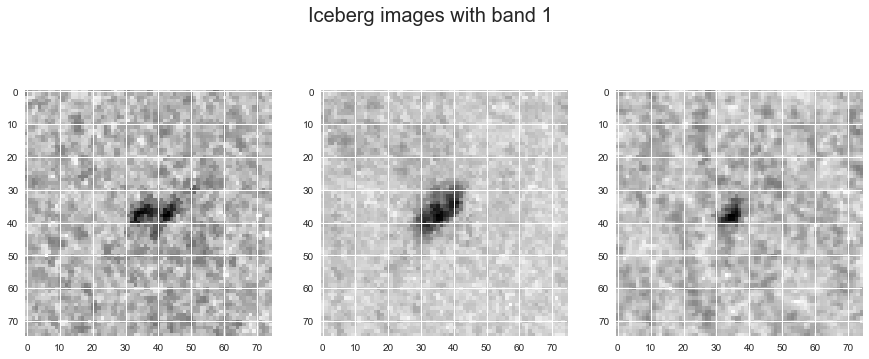

In [10]:
# Get 3 random icebergs
df_plot = train_df.loc[train_df['is_iceberg'] == True].sample(3)

plt.figure(figsize=(15,6))
for i in range(3):
     # we will set the current subplot
    plt.subplot(1,3,(i+1))
     # Then we will reshape the array to 75x75
    image = np.array(df_plot.iloc[i]['band_1']).reshape((75,75)).astype(np.float32)
    plt.imshow(image)
    # finally we will set the title as
plt.suptitle('Iceberg images with band 1',fontsize=20)

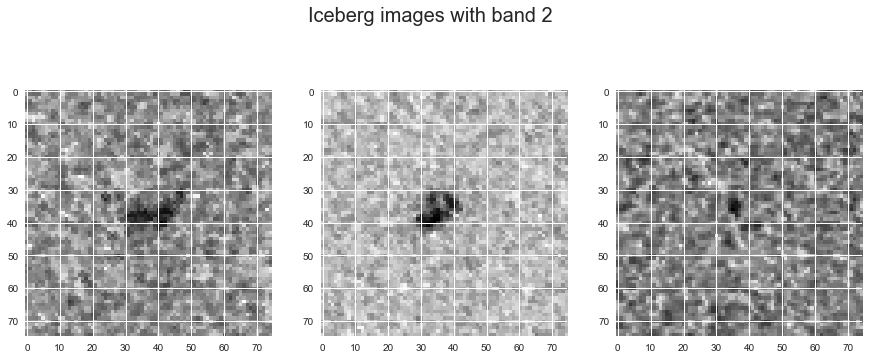

In [11]:
plt.figure(figsize=(15,6))
for i in range(3):
     # Set the current subplot
    plt.subplot(1,3,(i+1))
    # Reshape the array to 75x75
    image = np.array(df_plot.iloc[i]['band_2']).reshape((75,75)).astype(np.float32)
    plt.imshow(image)
    

plt.suptitle('Iceberg images with band 2',fontsize=20)

Images for boats.

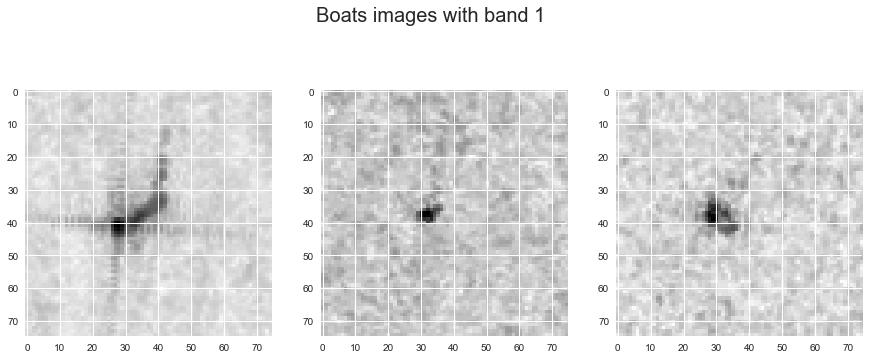

In [12]:
# FIrst get 9 random boats
df_plot = train_df.loc[train_df['is_iceberg'] == False].sample(3)

plt.figure(figsize=(15,6))
for i in range(3):
     # Set the current subplot
    plt.subplot(1,3,(i+1))
    # Reshape the array to 75x75
    image = np.array(df_plot.iloc[i]['band_1']).reshape((75,75)).astype(np.float32)
    plt.imshow(image)

    
plt.suptitle('Boats images with band 1', fontsize=20)

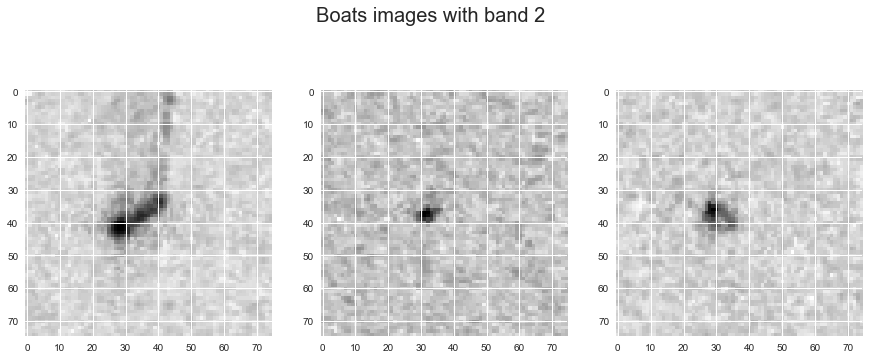

In [13]:
plt.figure(figsize=(15,6))
for i in range(3):
    plt.subplot(1,3,(i+1))
    image = np.array(df_plot.iloc[i]['band_2']).reshape((75,75)).astype(np.float32)
    plt.imshow(image)

    
plt.suptitle('Boats images with band 2', fontsize=20)

From above image visualization, both band 1 and band 2 show some information about the iceberg/ship. We will use both to train the algorithm. Since the prediction based on images, and we don't have more details, it seems fit Convolutional Neutral Network(CNN). There are many approach to realizing CNN, we have done some research and found that Keras is a popular tool to apply CNN. It is easy to implement. We can find that everything looks blob-like. In addition, the boats have a more regular structure.

## Installation of Keras

Before using Keras, we need to install all the package we will need in the system. Since we run this notebook locally on laptop, we follow the ways to install Keras:

1. Since we have installed conda before, we use the command in terminal to install the tensorflow of Keras:
conda install -c conda-forge keras tensorflow
2. Then, we are ready to install Keras use command:
conda install -c conda-forge keras
3. Refresh conda:
conda update -all
4. Reopen notebook and we are be able to use Keras.

## Modeling with Keras

Then, we can apply Keras on the well trained data. Same as using other packages, the first step is to import the packages we need.

In [14]:
from keras.models import Sequential
from keras.layers import Convolution2D, GlobalAveragePooling2D, Dense, Dropout

Using TensorFlow backend.


Fit a model using kera. Since the image is 2D, we added 2D functions into our model. We used 2 convolutional2D layers in the model, and for outputs, we applied sigmoid function on it. 

Since the training data is large, to avoid overfitting, we add Dropout() function to the model, and randomly set the fraction to 0.3. 

In [15]:
model = Sequential()
model.add(Convolution2D(32, 3, activation="relu", input_shape=(75, 75, 2)))
model.add(Convolution2D(64, 3, activation="relu", input_shape=(75, 75, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 32)        608       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 19,169
Trainable params: 19,169
Non-trainable params: 0
_________________________________________________________________


### Model fit and Validation Test

We use the training data to fit above model. The model.fit has defalt shuffle True, and we used the default setting to fit the training data. Since we need to plot the process of model fit, we choose epochs 20 in order to prevent some outliers that influence the evaluation of accuracy.

Before we test the model on test data, we need to see how well we did on this modeling. So, one way to do this is to seperate training data into 2 groups, one is for training and one is for testing. This method will give us relatively high accuracy on the results of the model's performance. The validation split value is the fraction of data that we will test on instead of train the data. To choose the validation split, we have examined several different values: 0.2, 0.25, 0.3, 0.35. And we found when validation split equal to 0.25, the training has higher accuracy and lower loss. 

Besides, for too large validation split, the training process will be under trained, and it will cause lose of accuracy while testing. In this case, we did not choose big validation split rate, say larger than 0.5.

In [16]:
history=model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=20)

Train on 1203 samples, validate on 401 samples
Epoch 1/20
1203/1203 [==============================] - 45s 37ms/step - loss: 1.4146 - acc: 0.5387 - val_loss: 0.6952 - val_acc: 0.5436
Epoch 2/20
1203/1203 [==============================] - 42s 35ms/step - loss: 0.6506 - acc: 0.6035 - val_loss: 0.6366 - val_acc: 0.5786
Epoch 3/20
1203/1203 [==============================] - 50s 41ms/step - loss: 0.6073 - acc: 0.6459 - val_loss: 0.6160 - val_acc: 0.5536
Epoch 4/20
1203/1203 [==============================] - 48s 40ms/step - loss: 0.5832 - acc: 0.6750 - val_loss: 0.6042 - val_acc: 0.5636
Epoch 5/20
1203/1203 [==============================] - 44s 37ms/step - loss: 0.5764 - acc: 0.6850 - val_loss: 0.5965 - val_acc: 0.5561
Epoch 6/20
1203/1203 [==============================] - 43s 36ms/step - loss: 0.5611 - acc: 0.6924 - val_loss: 0.6854 - val_acc: 0.5411
Epoch 7/20
1203/1203 [==============================] - 41s 34ms/step - loss: 0.5648 - acc: 0.6899 - val_loss: 0.6149 - val_acc: 0.5611
E

In [17]:
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


From the above keys for the model fit process, we have both loss rates and accuracy on train and test. To analysis the algorithm, we plot these data into two plots: model loss and model accuracy.

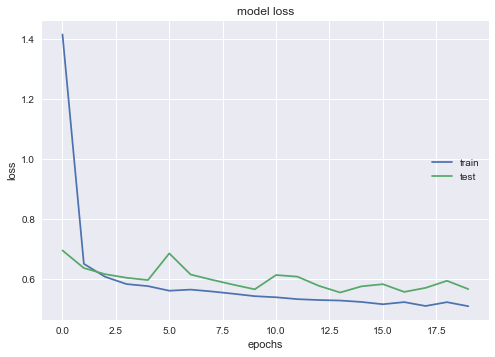

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','test'], loc = 'center right')

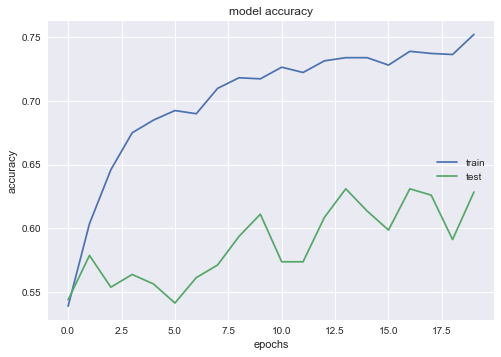

In [19]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'], loc = 'center right')

The model loss for training less than 0.5 and abouve 0.5 for testing. They are expected because the test data is much huge than training data. So the loss rate is slightly higher than training. For accuracy, we have about 0.8 for training and 0.7 for testing. Also, as the epochs increasing, the accuracy increase exponentially.

The result shows that this model is fine but not very highly performed since we still have about 30% of testing that are incorrect. Since ther training data set is much smaller than test data set, this result is expected. 

Finally, we do testing on the test data set. Since we don't know the actual type of the item in test images, we just simply show the probability for each image that is an iceberg at end. If the probability is higher than 0.5, we can see the item in images has higher probability to be an iceberg than a ship.

In [20]:
prediction = model.predict(X_test, verbose=1)

8424/8424 [==============================] - 85s 10ms/step


In [21]:
prediction.shape

(8424, 1)

In [22]:
prediction_result = pd.DataFrame({'id': test_df["id"], 'is_iceberg': prediction.flatten()})

In [23]:
print prediction_result

            id    is_iceberg
0     5941774d  6.177492e-01
1     4023181e  6.123359e-01
2     b20200e4  1.096204e-09
3     e7f018bb  6.421882e-01
4     4371c8c3  4.728980e-01
5     a8d9b1fd  4.798197e-04
6     29e7727e  6.413845e-01
7     92a51ffb  6.369935e-01
8     c769ac97  8.308526e-03
9     aee0547d  6.003667e-03
10    565b28ac  5.975043e-03
11    e04e9775  4.727769e-01
12    8e8161d1  2.840426e-01
13    4cf4d256  6.616011e-01
14    139e5324  2.304957e-03
15    f156976f  4.779123e-01
16    68a117cc  1.094894e-01
17    d9aa7a56  2.403551e-03
18    9005b143  2.465676e-02
19    5f6d3988  6.572278e-01
20    9ad70954  5.484474e-01
21    b9087b9e  6.514201e-01
22    a39a1427  9.973907e-02
23    82fbe8ed  6.414436e-01
24    1fae4879  7.770701e-06
25    6dd8f13d  4.441159e-03
26    bbad5958  6.070604e-01
27    54527583  2.217420e-01
28    be8fa29c  4.623098e-01
29    81a3328f  5.878842e-01
...        ...           ...
8394  8ae30ce6  1.086932e-03
8395  de27ed88  6.304654e-07
8396  66d5196f

## Conclusion

We have applied CNN on the data sets, and well organized the data so that they are good for training and testing.
The model we build for this challenge is not perfect but a simply implement of CNN using Keras. There might be some ways to improve the result. For example, may be evaluate the item size to help to predict the classification. Or maybe evaluate the level of the lightness of the item will help. For simply using CNN, we have got the results that we expected.